# EpiPINN

Physics-informed neural network learning epidemiological parameters

### Antonio Jimenez AOJ268
### Ashton Cole AVC687

## Contents

- Definitions
- Experiments
    - Experiment 1: Parameter estimation with exact data
    - Experiment 2: Parameter estimation with noisy data
    - Experiment 3: Parameter estimation and forecasting with noisy limited data

## Definitions

In [367]:
from caputo import caputo_euler
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [368]:
class PINN(nn.Module):
    def __init__(self, hidden_size, depth):
        super().__init__()
        # input t
        layers = [nn.Linear(1, hidden_size), nn.Tanh()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        # Output layer with 5 units for (s, e, i, r, d)
        layers.append(nn.Linear(hidden_size, 5))
        # Add softmax to enforce all components are positive and sum to 1
        layers.append(nn.Softmax(dim=1))
        
        self.net = nn.Sequential(*layers)

        self.init_weights() # Call the initialization method

    def init_weights(self):
        """Applies Xavier Uniform initialization."""
        for module in self.net.modules():
            if isinstance(module, nn.Linear): # only initialize linear layers
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None: # initialize biases to zero
                    nn.init.constant_(module.bias, 0)

    def forward(self, t):
        return self.net(t)

In [369]:
# Credit Google Gemini
def toeplitz(c, r):
    """
    Creates a Toeplitz matrix from a given first column (c) and first row (r).

    Args:
        c (torch.Tensor): A 1D tensor representing the first column of the Toeplitz matrix.
        r (torch.Tensor): A 1D tensor representing the first row of the Toeplitz matrix.
                          The first element of r should be equal to the first element of c.

    Returns:
        torch.Tensor: The constructed Toeplitz matrix.
    """
    if c[0] != r[0]:
        raise ValueError("The first element of 'c' and 'r' must be the same.")

    vals = torch.cat((r, c[1:].flip(0)))
    shape = len(c), len(r)
    i, j = torch.ones(*shape).nonzero().T
    return vals[j - i].reshape(*shape)

In [370]:
def torch_caputo_l1_diff(psis, alpha, dt=1.0, ts=None):
    """Compute approximate Caputo fractional derivative using the L1 scheme.

    Args:
        psi (torch.tensor): A series of function values. In agreement with pytorch machine learning conventions, this tensor is two-dimensional, and the first dimension corresponds to the dependent variable.
        alpha (torch.tensor): The order of the derivative, in the range (0.0, 1.0].
        dt=1.0 (float): If the corresponding dependent variable series is not provided, the uniform step size between function evaluations.
        ts=None (np.ndarray): The corresponding dependent variable series, used if there is a variable step size.

    Returns:
        An torch.tensor containing the series of fractional derivatives.
    """
    psips = torch.zeros(psis.shape, dtype=psis.dtype, device=psis.device)
    C = dt ** (-alpha) / torch.exp(torch.lgamma(2.0 - alpha))
    dpsis = psis[1:, :] - psis[:-1, :]
    if ts is None:
        rs = torch.arange(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        ws = (rs + 1) ** (1.0 - alpha) - rs ** (1.0 - alpha)
        row = torch.zeros(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        row[0] = ws[0] # Lower triangular matrix
        A = toeplitz(ws, row)
        psips[1:, :] = C * A @ dpsis
    else:
        raise NotImplementedError('Variable time step differentiation not yet implemented!')
    return psips

In [371]:
def caputo_l1_diff_broken(psi, alpha, dt):
    n = len(psi)
    # The derivative at t=0 is undefined for the L1 scheme
    derivatives = [torch.zeros(1, 1, device=psi.device)] 
    
    # Pre-compute the log of the gamma function part for stability
    log_gamma_term = torch.lgamma(2.0 - alpha)

    for i in range(1, n):
        # Make vector of k values from 0 to i-1
        k = torch.arange(i, dtype=torch.float32, device=psi.device)
        
        # Calculate weights c_k^(i) 
        weights = ((k + 1)**(1 - alpha) - k**(1 - alpha))
        
        # Get the differences psi(t_{i-k}) - psi(t_{i-k-1})
        psi_diffs = psi[i - k.long()] - psi[i - k.long() - 1]
        
        summation = torch.sum(weights * psi_diffs.squeeze())
        
        # Combine everything to get the derivative at time t_i
        deriv_at_i = (1.0 / (dt**alpha * torch.exp(log_gamma_term))) * summation
        derivatives.append(deriv_at_i.unsqueeze(0))
        
    return torch.cat(derivatives).unsqueeze(1)

In [372]:
class EpiPINN(nn.Module):
    def __init__(self, hidden_size, depth, initial_params):
        super().__init__()
        
        self.pinn = PINN(hidden_size, depth) 
        # trainable params
        # x + torch.log(-torch.expm1(-x))
        self.raw_beta = nn.Parameter(torch.tensor([initial_params['beta'] + np.log(-np.expm1(-initial_params['beta']))], dtype=torch.float32))
        self.raw_sigma = nn.Parameter(torch.tensor([initial_params['sigma'] + np.log(-np.expm1(-initial_params['sigma']))], dtype=torch.float32))
        self.raw_gamma = nn.Parameter(torch.tensor([initial_params['gamma'] + np.log(-np.expm1(-initial_params['gamma']))], dtype=torch.float32))
        self.raw_mu = nn.Parameter(torch.tensor([initial_params['mu'] + np.log(-np.expm1(-initial_params['mu']))], dtype=torch.float32))
        # Init z_alpha such that the init alpha is close to 1.0
        self.z_alpha = nn.Parameter(torch.tensor([initial_params['z_alpha']], dtype=torch.float32)) # sigmoid(2.94) is approx 0.95
        
        self.min_alpha = initial_params['min_alpha'] # Example minimum value for alpha
        self.dt = initial_params['dt']

    def beta(self):
        return nn.functional.softplus(self.raw_beta)

    def sigma(self):
        return nn.functional.softplus(self.raw_sigma)

    def gamma(self):
        return nn.functional.softplus(self.raw_gamma)
        
    def mu(self):
        return nn.functional.softplus(self.raw_mu)

    def alpha(self):
        # Restrict alpha to a specific range, (min_alpha, 1.0] 
        return self.min_alpha + (1.0 - self.min_alpha) * torch.sigmoid(self.z_alpha)
    
    def forward(self, t):
        return self.pinn(t)

    def get_loss_ic(self, ts, ic, y_pred=None):
        """Get initial condition loss of model.

        Arguments:
            ts (torch.tensor): Time points for the model, assuming t[0] is the initial time. Only t[0] is needed, but the tensor dimensions must be consistent.
            ic (torch.tensor): The initial state to enforce.
            y_pred=None (torch.tensor): Predictions at time points, if already computed. Only y[0] is needed, but the tensor dimensions must be consistent.

        Returns:
            squared l2 norm of initial condition error
        """
        # IC loss
        t_initial = ts[0].unsqueeze(0) # get t_0
        y_initial_pred = self.forward(t_initial) if y_pred == None else y_pred[0, :].unsqueeze(0)
        return nn.functional.mse_loss(y_initial_pred, ic)

    def get_loss_data(self, t_data, y_data, y_data_pred=None):
        """Get data loss of model.

        Arguments:
            t_data (torch.tensor): Training data times.
            y_data (torch.tensor): Corresponding state data.
            y_data_pred=None (torch.tensor): Predictions at data points, if already computed.

        Returns:
            MSE loss (squared l2 norm) of data error
        """
        # Data Loss
        y_data_pred = self.forward(t_data) if y_data_pred == None else y_data_pred
        return nn.functional.mse_loss(y_data_pred, y_data)

    def get_loss_phys(self, t_colloc, y_colloc_pred=None):
        """Get physics loss of model.

        Arguments:
            t_colloc (torch.tensor): Times at which to compute the loss.
            y_colloc_pred=None (torch.tensor): Predictions at collocation points, if already computed.

        Returns:
            squared l2 norm of residual
        """
        # Phys Loss
        y_colloc_pred = self.forward(t_colloc)
        s,e,i,r,d = y_colloc_pred.unbind(1)
        s = s.unsqueeze(1)
        e = e.unsqueeze(1)
        i = i.unsqueeze(1)
        r = r.unsqueeze(1)
        d = d.unsqueeze(1)
        ds_dt = torch_caputo_l1_diff(s, self.alpha(), self.dt)
        de_dt = torch_caputo_l1_diff(e, self.alpha(), self.dt)
        di_dt = torch_caputo_l1_diff(i, self.alpha(), self.dt)
        dr_dt = torch_caputo_l1_diff(r, self.alpha(), self.dt)
        dd_dt = torch_caputo_l1_diff(d, self.alpha(), self.dt)

        # calculate RHS of equation 4
        num_living =  1 - d
        f_s = -self.beta() * s * i / num_living
        f_e = (self.beta() * s * i / num_living) - self.sigma() * e
        f_i = (self.sigma() * e) - (self.gamma()+ self.mu()) * i
        f_r = self.gamma() * i
        f_d = self.mu() * i

        # calc residuals (LHS - RHS = 0)
        residual_s = ds_dt - f_s
        residual_e = de_dt - f_e
        residual_i = di_dt - f_i
        residual_r = dr_dt - f_r
        residual_d = dd_dt - f_d

        all_residuals = torch.cat([residual_s, residual_e, residual_i, residual_r, residual_d], dim=1)
        loss_phys = torch.mean(all_residuals**2)
        return loss_phys

In [373]:
def train_stage1(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage one of EpiPINN training process.

    In this stage, only the weights of the neural network are trained to minimize the data and initial condition loss.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []

    # Ensure epidemiological parameters are not trained
    model.raw_beta.requires_grad = False
    model.raw_sigma.requires_grad = False
    model.raw_gamma.requires_grad = False
    model.raw_mu.requires_grad = False
    model.z_alpha.requires_grad = False

    # Set to training mode
    model.train()

    # Train with early stopping
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = model.get_loss_phys(t_colloc)
        loss = loss_data + loss_ic # Physics is not used for gradient descent

        # Record losses
        losses.append(loss.item() + loss_phys.item()) # Physics is recored, not mimimized
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > 500 or loss.item() < 1e-6:
            break

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')
    
    # Set to evaluation mode
    model.eval()
        
    return losses, losses_data, losses_ic, losses_phys

In [374]:
def adaptive_weight(lambda_val):
        """Calculate adaptive weight using a scaled sigmoid function."""
        return 100 / (1 + torch.exp(-lambda_val))

def train_stage2(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage two of EpiPINN training process.

    In this stage, both the weights of the neural network and epidemiological parameters are trained to minimize the data, initial condition, and physics losses.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []
    alphas = []
    betas = []
    sigmas = []
    gammas = []
    mus = []

    # Ensure epidemiological parameters are trained
    model.raw_beta.requires_grad = True
    model.raw_sigma.requires_grad = True
    model.raw_gamma.requires_grad = True
    model.raw_mu.requires_grad = True
    model.z_alpha.requires_grad = True

    
    # Initialize adaptive weights
    data_lambda = adaptive_weight(torch.tensor(0.0))
    ic_lambda = adaptive_weight(torch.tensor(0.0))
    phys_lambda = adaptive_weight(torch.tensor(0.0))

    adaptive_rate = 0.01

    # Set to training mode
    model.train()

    # Train with early stopping
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = model.get_loss_phys(t_colloc)
        
        data_lambda = data_lambda + adaptive_rate * loss_data.detach() * 100 * torch.exp(-data_lambda) / (1 + torch.exp(-data_lambda))**2
        ic_lambda = ic_lambda + adaptive_rate * loss_ic.detach() * 100 * torch.exp(-ic_lambda) / (1 + torch.exp(-ic_lambda))**2
        phys_lambda = phys_lambda + adaptive_rate * loss_ic.detach() * 100 * torch.exp(-phys_lambda) / (1 + torch.exp(-phys_lambda))**2
        
        # Update adaptive weights
        w_ic = adaptive_weight(ic_lambda)
        w_phys = adaptive_weight(phys_lambda)
        w_data = adaptive_weight(data_lambda)
        loss = w_data * loss_data + w_ic * loss_ic + w_phys * loss_phys


        # Record losses
        losses.append(loss.item())
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Record epidemiological parameters
        alphas.append(model.alpha().item())
        betas.append(model.beta().item())
        sigmas.append(model.sigma().item())
        gammas.append(model.gamma().item())
        mus.append(model.mu().item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > 500 or loss.item() < 1e-6:
            break

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')

    # Set to evaluation mode
    model.eval()
    
    return losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus

## Experiments

### Experiment 1: Parameter estimation with exact data

This experiment is a recreation of the Mpox synthetic case found in the paper. We were unable to find the synthetic time series data $(s, e, i, r, d)(t)$ from the cited source, so we instead implemented a fractional ODE solver to generate data consistent with the provided epidemiological parameters.

In [375]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

D[s] = -0.0, s = 0.99
D[s] = -0.0007841305629861977, s = 0.9880890109096844
D[s] = -0.0011552957512042438, s = 0.9854036530858722
D[s] = -0.0014747388145720337, s = 0.9820474532817111
D[s] = -0.0018058120831112349, s = 0.9779884712069988
D[s] = -0.002177553004133218, s = 0.9731325089097256
D[s] = -0.0026069520732444483, s = 0.9673501488153666
D[s] = -0.0031074122108668404, s = 0.9604842071003005
D[s] = -0.0036914567130479645, s = 0.952351374039053
D[s] = -0.004371563257419124, s = 0.94274221864231
D[s] = -0.005160200306680222, s = 0.9314212831716681
D[s] = -0.006069391183102033, s = 0.9181282811684137
D[s] = -0.007109877002992552, s = 0.9025812701711294
D[s] = -0.008289861267395766, s = 0.8844827160715232
D[s] = -0.009613298609109951, s = 0.8635294474068337
D[s] = -0.011077713820837881, s = 0.8394275164141722
D[s] = -0.012671605298781214, s = 0.8119128391381225
D[s] = -0.014371607265886066, s = 0.7807780616211963
D[s] = -0.016139761945860632, s = 0.7459052677418145
D[s] = -0.0179214749

In [376]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [377]:
# Load model if already generated

In [378]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5),
    epochs=5000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.002576
Epoch [200/5000], Loss: 0.001360
Epoch [300/5000], Loss: 0.001117
Epoch [400/5000], Loss: 0.000893
Epoch [500/5000], Loss: 0.000690
Epoch [600/5000], Loss: 0.000493
Epoch [700/5000], Loss: 0.000252
Epoch [800/5000], Loss: 0.000109
Epoch [900/5000], Loss: 0.000065
Epoch [1000/5000], Loss: 0.000043
Epoch [1100/5000], Loss: 0.000034
Epoch [1200/5000], Loss: 0.000029
Epoch [1300/5000], Loss: 0.000025
Epoch [1400/5000], Loss: 0.000023
Epoch [1500/5000], Loss: 0.000022
Epoch [1600/5000], Loss: 0.000028
Epoch [1700/5000], Loss: 0.000030
Epoch [1800/5000], Loss: 0.000018
Epoch [1900/5000], Loss: 0.000017
Epoch [2000/5000], Loss: 0.000017
Epoch [2100/5000], Loss: 0.000016
Epoch [2200/5000], Loss: 0.000023
Epoch [2300/5000], Loss: 0.000054
Epoch [2400/5000], Loss: 0.000019
Epoch [2500/5000], Loss: 0.000023
Epoch [2600/5000], Loss: 0.000015
Epoch [2700/5000], Loss: 0.000014
Epoch [2800/5000], Loss: 0.000014
Epoch [2900/5000], Loss: 0.000014
Epoch [3000/5000], Loss

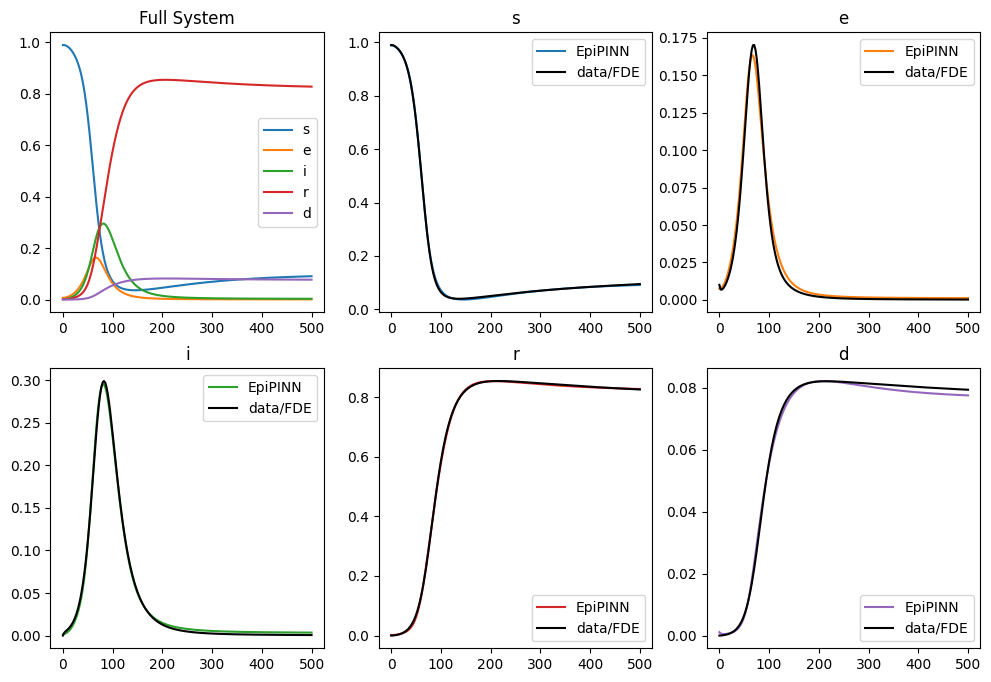

In [379]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

In [380]:
model1.get_loss_phys(ts_colloc)

tensor(3.2653e-06, grad_fn=<MeanBackward0>)

In [381]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.001326
Epoch [200/2000], Loss: 0.001218
Epoch [300/2000], Loss: 0.001118
Epoch [400/2000], Loss: 0.001022
Epoch [500/2000], Loss: 0.000931
Epoch [600/2000], Loss: 0.000845
Epoch [700/2000], Loss: 0.000767
Epoch [800/2000], Loss: 0.000696
Epoch [900/2000], Loss: 0.000632
Epoch [1000/2000], Loss: 0.000573
Epoch [1100/2000], Loss: 0.000521
Epoch [1200/2000], Loss: 0.000477
Epoch [1300/2000], Loss: 0.000555
Epoch [1400/2000], Loss: 0.000404
Epoch [1500/2000], Loss: 0.000374
Epoch [1600/2000], Loss: 0.000348
Epoch [1700/2000], Loss: 0.000326
Epoch [1800/2000], Loss: 0.000305
Epoch [1900/2000], Loss: 0.000287
Epoch [2000/2000], Loss: 0.000271
Complete in 22.698695182800293 seconds
alpha = 0.9454299807548523
beta = 0.21308337152004242
gamma = 0.043678708374500275
sigma = 0.11107520014047623
mu = 0.006061664782464504


In [382]:
# Save model
torch.save(model1.state_dict(), 'experiment1.pth')

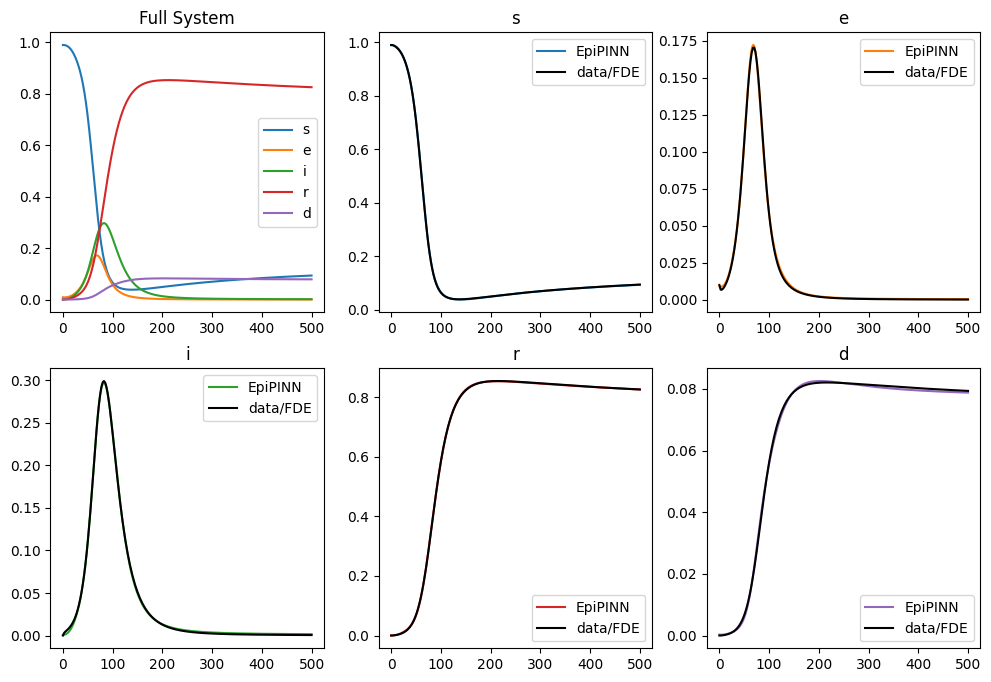

In [383]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

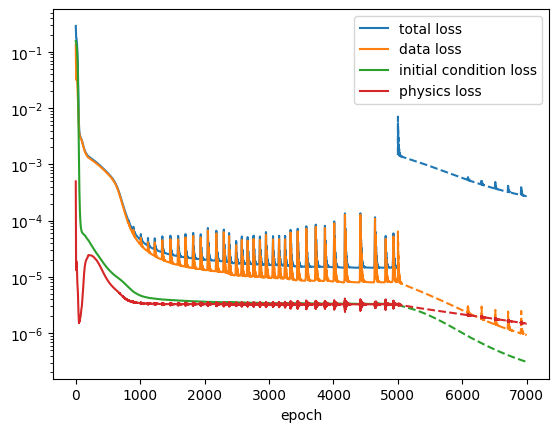

In [384]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

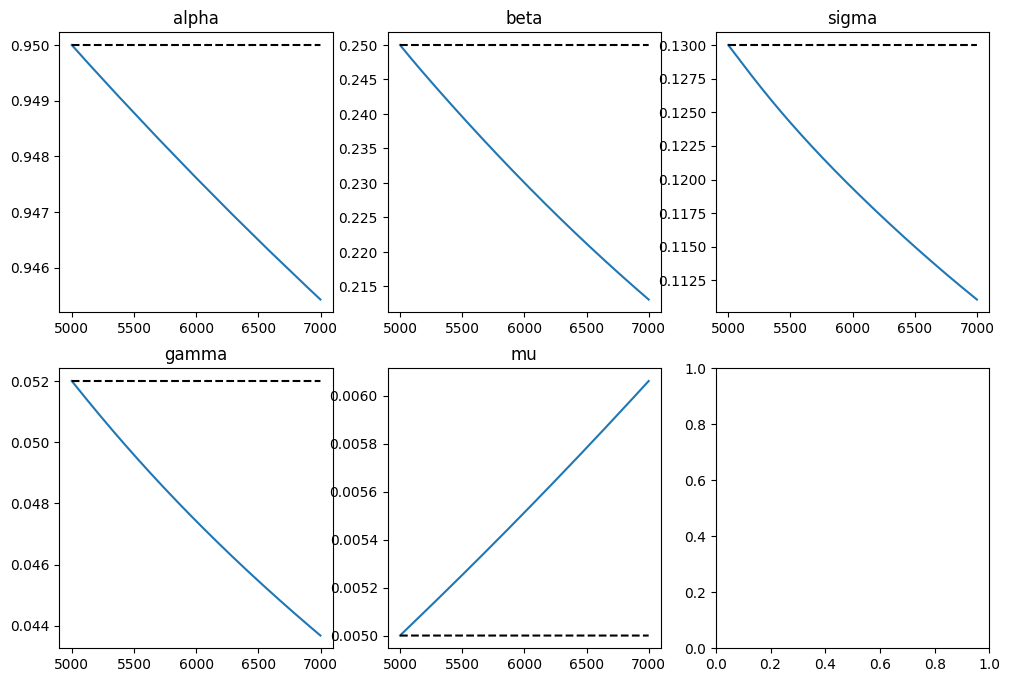

In [385]:
 # Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

### Experiment 2: Parameter estimation with noisy data

This experiment is also a recreation of the Mpox synthetic case found in the paper. Now random noise is added to the data to test the model's abitilty to recover the ideal model.

In [386]:
def add_noise(ys, noise_level):
    """Add Gaussian noise to a signal.

    Args:
        ys (numpy.ndarray): The clean signal to which noise will be added.
        noise_level (float): Standard deviation of the Gaussian noise to add,
                             relative to the standard deviation of the input signal.

    Returns:
        numpy.ndarray: The noisy signal.
    """
    if noise_level <= 0.0:
        return ys
    # Calc magnitude based on standard deviation of the signal
    std_dev_ys = np.std(ys, axis=0 if ys.ndim > 1 else None)
    noise_scale = noise_level * np.where(std_dev_ys < 1e-10, 1.0, std_dev_ys)
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    ys_noisy = ys + noise

    return ys_noisy

In [387]:
def generate_true_data():
    # ranges determined by table 1 and 3
    alpha_min, alpha_max = 0.9, 1.0
    beta_min, beta_max = 0.1, 0.4
    sigma_min, sigma_max = 0.077, 0.3
    gamma_min, gamma_max = 0.036, 0.1
    mu_min, mu_max = 0.001, 0.03

    alpha_true = random.uniform(alpha_min, alpha_max)
    beta_true = random.uniform(beta_min, beta_max)
    sigma_true = random.uniform(sigma_min, sigma_max)
    gamma_true = random.uniform(gamma_min, gamma_max)
    mu_true = random.uniform(mu_min, mu_max)
    return alpha_true, beta_true, sigma_true, gamma_true, mu_true

In [388]:
# Data generation
alpha_true, beta_true, sigma_true, gamma_true, mu_true = generate_true_data()
print(f'True parameters: alpha={alpha_true:.4f}, beta={beta_true:.4f}, sigma={sigma_true:.4f}, gamma={gamma_true:.4f}, mu={mu_true:.4f}')

y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

# Add noise to data
noise_level = 0.1 # 10% noise
ys_noisy = add_noise(ys, noise_level)
ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys_noisy, dtype=torch.float32)

True parameters: alpha=0.9983, beta=0.1370, sigma=0.2027, gamma=0.0570, mu=0.0127
D[s] = -0.0, s = 0.99
D[s] = -0.0006867815386108992, s = 0.9882844761801777
D[s] = -0.0009033482296971177, s = 0.986031995178594
D[s] = -0.001028552249474374, s = 0.9834695386527641
D[s] = -0.001141614170187617, s = 0.9806268493259783
D[s] = -0.0012601271355105002, s = 0.9774900965850177
D[s] = -0.0013885605896631948, s = 0.9740344561601473
D[s] = -0.001528560217990725, s = 0.9702310774777729
D[s] = -0.0016811582288817285, s = 0.9660485804189001
D[s] = -0.0018472464103844713, s = 0.9614533903126757
D[s] = -0.0020276688979788716, s = 0.9564098493005222
D[s] = -0.0022232277197910383, s = 0.9508803173725486
D[s] = -0.0024346650371004233, s = 0.9448253193821637
D[s] = -0.002662636045562931, s = 0.9382037604833132
D[s] = -0.002907675494875561, s = 0.9309732254670579
D[s] = -0.0031701584021527397, s = 0.9230903762236222
D[s] = -0.003450255150156389, s = 0.9145114611673535
D[s] = -0.003747881312445353, s = 0.905

In [389]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model_noisy = EpiPINN(hidden_size, depth, initial_params)

In [390]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-2, weight_decay=1e-5),
    epochs=4000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/4000], Loss: 0.003627
Epoch [200/4000], Loss: 0.001008
Epoch [300/4000], Loss: 0.000573
Epoch [400/4000], Loss: 0.000588
Epoch [500/4000], Loss: 0.000454
Epoch [600/4000], Loss: 0.000371
Epoch [700/4000], Loss: 0.010358
Epoch [800/4000], Loss: 0.000501
Epoch [900/4000], Loss: 0.000371
Epoch [1000/4000], Loss: 0.000318
Epoch [1100/4000], Loss: 0.000297
Epoch [1200/4000], Loss: 0.000287
Epoch [1300/4000], Loss: 0.000282
Epoch [1400/4000], Loss: 0.000279
Epoch [1500/4000], Loss: 0.000278
Epoch [1600/4000], Loss: 0.000278
Epoch [1700/4000], Loss: 0.000465
Epoch [1800/4000], Loss: 0.000277
Epoch [1900/4000], Loss: 0.000279
Epoch [2000/4000], Loss: 0.000280
Epoch [2100/4000], Loss: 0.000291
Epoch [2200/4000], Loss: 0.000299
Epoch [2300/4000], Loss: 0.000290
Complete in 12.275570154190063 seconds
alpha = 0.949999988079071
beta = 0.25
gamma = 0.05199999734759331
sigma = 0.12999999523162842
mu = 0.004999999888241291


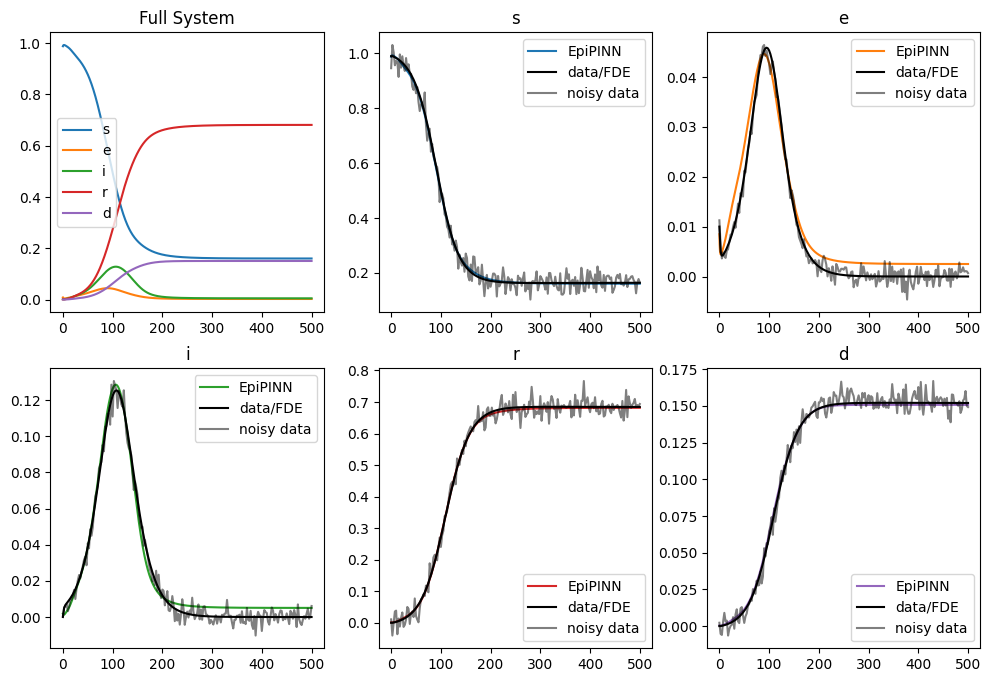

In [391]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)


for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

In [392]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model_noisy,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model_noisy.parameters(), lr=1e-4, weight_decay=1e-5),
    epochs=4000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model_noisy.alpha().item()}')
print(f'beta = {model_noisy.beta().item()}')
print(f'gamma = {model_noisy.gamma().item()}')
print(f'sigma = {model_noisy.sigma().item()}')
print(f'mu = {model_noisy.mu().item()}')

Epoch [100/4000], Loss: 0.028051
Epoch [200/4000], Loss: 0.027745
Epoch [300/4000], Loss: 0.027537
Epoch [400/4000], Loss: 0.027384
Epoch [500/4000], Loss: 0.027275
Epoch [600/4000], Loss: 0.027189
Epoch [700/4000], Loss: 0.027112
Epoch [800/4000], Loss: 0.027042
Epoch [900/4000], Loss: 0.026977
Epoch [1000/4000], Loss: 0.026919
Epoch [1100/4000], Loss: 0.026871
Epoch [1200/4000], Loss: 0.026832
Epoch [1300/4000], Loss: 0.026794
Epoch [1400/4000], Loss: 0.026761
Epoch [1500/4000], Loss: 0.026735
Epoch [1600/4000], Loss: 0.026704
Epoch [1700/4000], Loss: 0.026680
Epoch [1800/4000], Loss: 0.026653
Epoch [1900/4000], Loss: 0.026630
Epoch [2000/4000], Loss: 0.026607
Epoch [2100/4000], Loss: 0.026585
Epoch [2200/4000], Loss: 0.026564
Epoch [2300/4000], Loss: 0.026543
Epoch [2400/4000], Loss: 0.026523
Epoch [2500/4000], Loss: 0.026504
Epoch [2600/4000], Loss: 0.026486
Epoch [2700/4000], Loss: 0.026469
Epoch [2800/4000], Loss: 0.026453
Epoch [2900/4000], Loss: 0.026438
Epoch [3000/4000], Loss

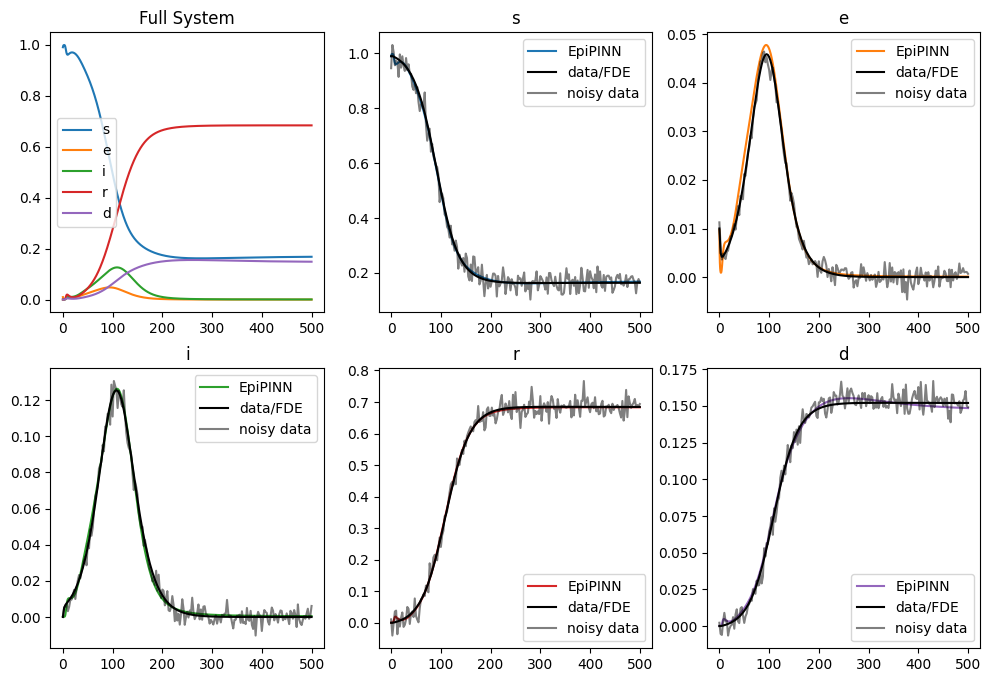

In [393]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model_noisy.eval()
with torch.no_grad():
    ys_val = model_noisy(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys_noisy[:, i], label='noisy data', color='k', alpha=0.5)


for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

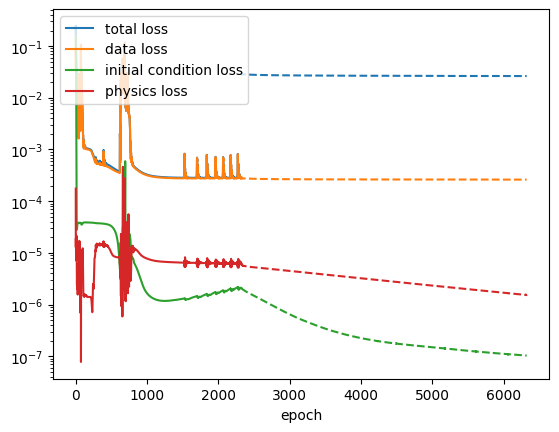

In [394]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

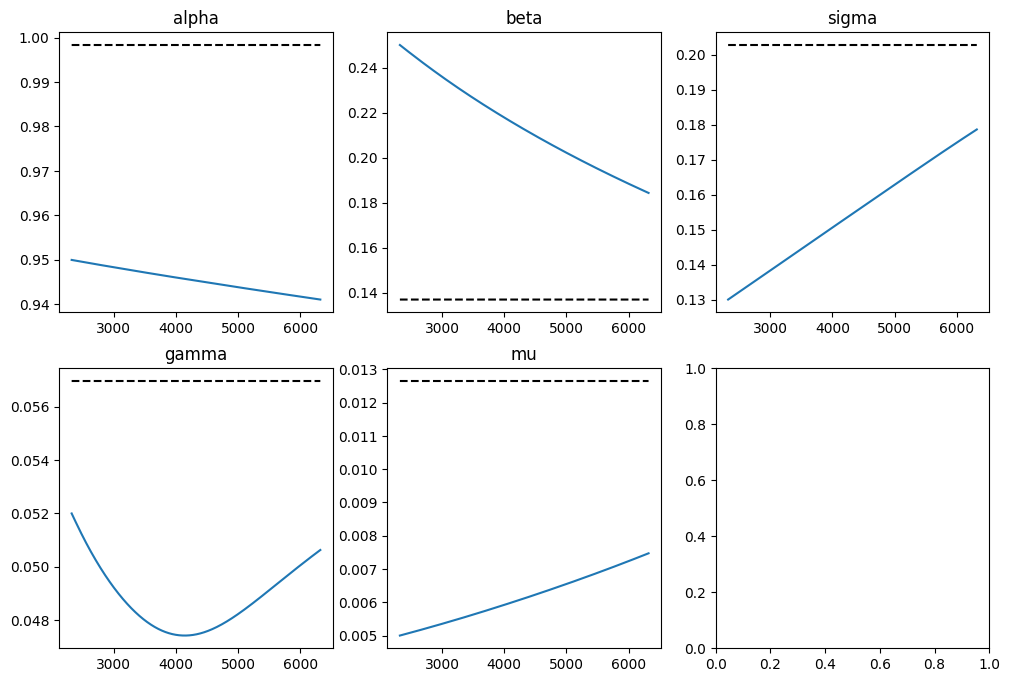

In [395]:
 # Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

# Revised Experiment 1, freezing parameters

In [396]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

D[s] = -0.0, s = 0.99
D[s] = -0.0007841305629861977, s = 0.9880890109096844
D[s] = -0.0011552957512042438, s = 0.9854036530858722
D[s] = -0.0014747388145720337, s = 0.9820474532817111
D[s] = -0.0018058120831112349, s = 0.9779884712069988
D[s] = -0.002177553004133218, s = 0.9731325089097256
D[s] = -0.0026069520732444483, s = 0.9673501488153666
D[s] = -0.0031074122108668404, s = 0.9604842071003005
D[s] = -0.0036914567130479645, s = 0.952351374039053
D[s] = -0.004371563257419124, s = 0.94274221864231
D[s] = -0.005160200306680222, s = 0.9314212831716681
D[s] = -0.006069391183102033, s = 0.9181282811684137
D[s] = -0.007109877002992552, s = 0.9025812701711294
D[s] = -0.008289861267395766, s = 0.8844827160715232
D[s] = -0.009613298609109951, s = 0.8635294474068337
D[s] = -0.011077713820837881, s = 0.8394275164141722
D[s] = -0.012671605298781214, s = 0.8119128391381225
D[s] = -0.014371607265886066, s = 0.7807780616211963
D[s] = -0.016139761945860632, s = 0.7459052677418145
D[s] = -0.0179214749

In [397]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [398]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-2),
    epochs=5000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.025381
Epoch [200/5000], Loss: 0.021061
Epoch [300/5000], Loss: 0.000496
Epoch [400/5000], Loss: 0.000124
Epoch [500/5000], Loss: 0.000072
Epoch [600/5000], Loss: 0.000056
Epoch [700/5000], Loss: 0.000047
Epoch [800/5000], Loss: 0.000033
Epoch [900/5000], Loss: 0.000006
Epoch [1000/5000], Loss: 0.000013
Epoch [1100/5000], Loss: 0.000021
Epoch [1200/5000], Loss: 0.000010
Epoch [1300/5000], Loss: 0.000003
Epoch [1400/5000], Loss: 0.000054
Epoch [1500/5000], Loss: 0.000037
Epoch [1600/5000], Loss: 0.000092
Epoch [1700/5000], Loss: 0.000015
Epoch [1800/5000], Loss: 0.000025
Epoch [1900/5000], Loss: 0.000030
Epoch [2000/5000], Loss: 0.000043
Epoch [2100/5000], Loss: 0.000009
Epoch [2200/5000], Loss: 0.000008
Epoch [2300/5000], Loss: 0.000059
Epoch [2400/5000], Loss: 0.000065
Epoch [2500/5000], Loss: 0.000038
Epoch [2600/5000], Loss: 0.000004
Epoch [2700/5000], Loss: 0.000024
Epoch [2800/5000], Loss: 0.000019
Epoch [2900/5000], Loss: 0.000064
Epoch [3000/5000], Loss

In [399]:
# Freeze all parameters, weights and epidemiological parameters
# In the second stage, epidemiological parameters will be re-activated
for param in model1.parameters():
    param.requires_grad = False

In [400]:
# Start timing
start2 = time.time()

# Stage 2: epidemiological parameters ONLY, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-4),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.003341
Epoch [200/2000], Loss: 0.003328
Epoch [300/2000], Loss: 0.003315
Epoch [400/2000], Loss: 0.003303
Epoch [500/2000], Loss: 0.003292
Epoch [600/2000], Loss: 0.003281
Epoch [700/2000], Loss: 0.003270
Epoch [800/2000], Loss: 0.003260
Epoch [900/2000], Loss: 0.003250
Epoch [1000/2000], Loss: 0.003240
Epoch [1100/2000], Loss: 0.003231
Epoch [1200/2000], Loss: 0.003222
Epoch [1300/2000], Loss: 0.003214
Epoch [1400/2000], Loss: 0.003206
Epoch [1500/2000], Loss: 0.003198
Epoch [1600/2000], Loss: 0.003190
Epoch [1700/2000], Loss: 0.003183
Epoch [1800/2000], Loss: 0.003176
Epoch [1900/2000], Loss: 0.003169
Epoch [2000/2000], Loss: 0.003162
Complete in 19.114932537078857 seconds
alpha = 0.9454032182693481
beta = 0.2129291445016861
gamma = 0.04374302178621292
sigma = 0.11003898829221725
mu = 0.0041940645314753056


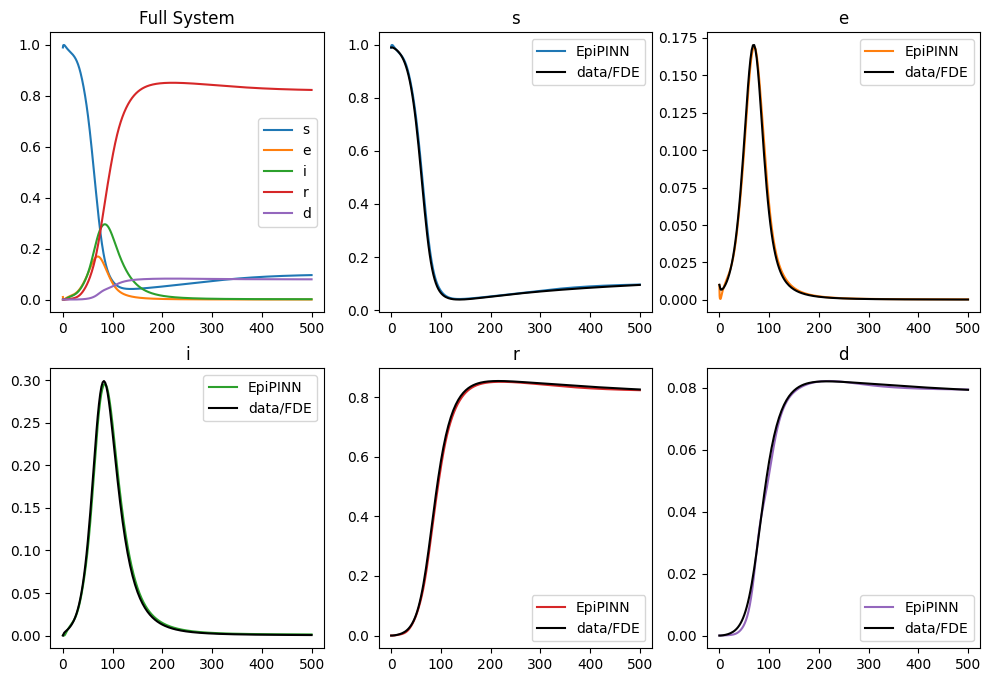

In [401]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

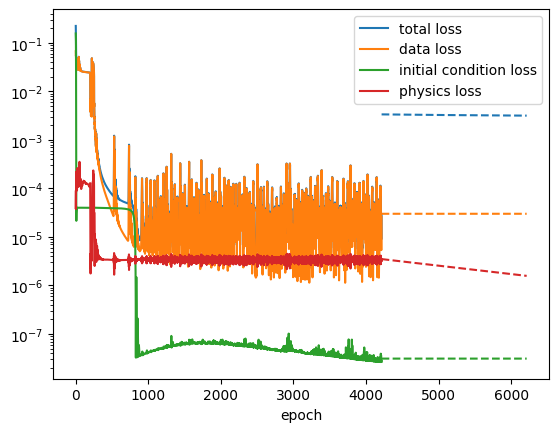

In [402]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

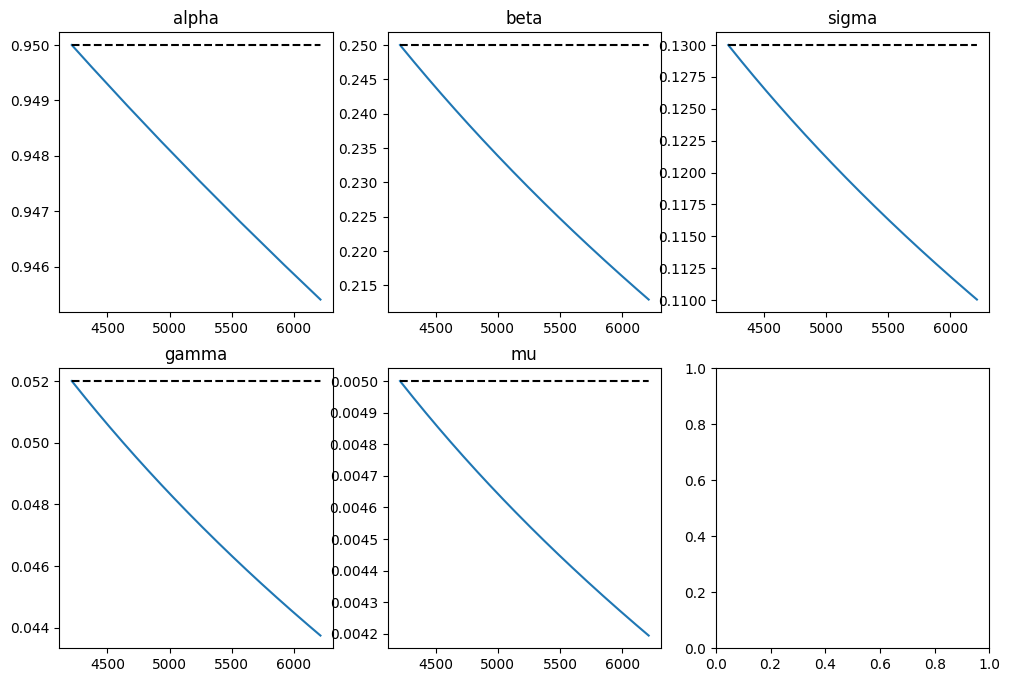

In [403]:
# Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

# Plot effects of different alphas

D[s] = -0.0, s = 0.99
D[s] = -0.002364665588254395, s = 0.984088336029364
D[s] = -0.00257753871404181, s = 0.9776444892442595
D[s] = -0.003594369881513898, s = 0.9686585645404747
D[s] = -0.004751238692989083, s = 0.9567804678080021
D[s] = -0.006306360161253496, s = 0.9410145674048683
D[s] = -0.008300383262118296, s = 0.9202636092495725
D[s] = -0.010830515637282568, s = 0.8931873201563661
D[s] = -0.013962798281813106, s = 0.8582803244518333
D[s] = -0.017717331827508558, s = 0.813986994883062
D[s] = -0.022015532459042187, s = 0.7589481637354565
D[s] = -0.026618679507077053, s = 0.6924014649677639
D[s] = -0.031069531239088722, s = 0.6147276368700421
D[s] = -0.03468031573084976, s = 0.5280268475429176
D[s] = -0.036629265364112346, s = 0.43645368413263674
D[s] = -0.036210990718844864, s = 0.3459262073355247
D[s] = -0.033189002168555075, s = 0.26295370191413703
D[s] = -0.02804532015641934, s = 0.19284040152308857
D[s] = -0.021874561531711308, s = 0.13815399769381032
D[s] = -0.015902664585568

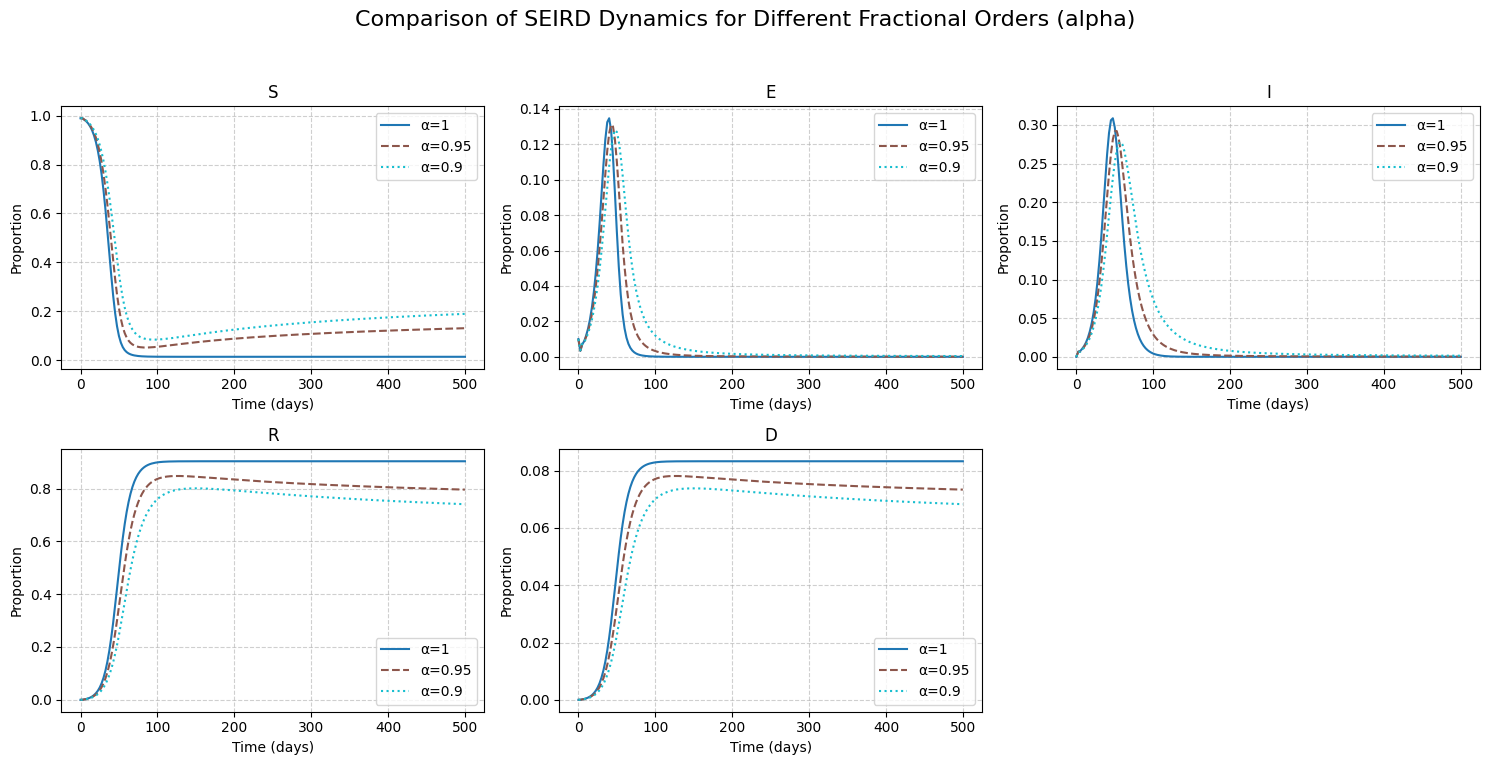

In [404]:
_, beta_true, sigma_true, gamma_true, mu_true = generate_true_data()
alphas = [1,.95,.9]
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests
f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])
fig, axs = plt.subplots(2, 3, figsize=(15, 8)) 
axs = axs.ravel() 
labels = ['S', 'E', 'I', 'R', 'D']
colors = plt.cm.tab10(np.linspace(0, 1, len(alphas)))
linestyles = ['-', '--', ':'] 

for idx, alpha_val in enumerate(alphas):
    ts, ys = caputo_euler(f, alpha_val, (t0, tf), num_step, y0)

    for i in range(5):
        axs[i].plot(ts, ys[:, i],
                    label=f'α={alpha_val}',
                    color=colors[idx],
                    linestyle=linestyles[idx])

for i in range(5):
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Time (days)')
    axs[i].set_ylabel('Proportion')
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Hide the unused 6th subplot
axs[5].axis('off')

plt.suptitle('Comparison of SEIRD Dynamics for Different Fractional Orders (alpha)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()
